In [8]:
# Import Required Libraries
import pandas as pd
import os
import re
from openpyxl import load_workbook
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

In [9]:
class SwissRentalRoomsDataExtractor:
    """
    A class to extract rental price data from Swiss rental price Excel files by room count.
    The Excel files contain data on average rental price per square meter by 
    number of rooms and canton in Switzerland.
    """
    
    def __init__(self, output_format='json'):
        """
        Initialize the extractor.
        
        Args:
            output_format (str): Format to save extracted data ('csv', 'json', or 'excel')
        """
        self.output_format = output_format
        self.supported_formats = ['csv', 'json', 'excel']
        if self.output_format not in self.supported_formats:
            raise ValueError(f"Output format must be one of {self.supported_formats}")
    
    def extract_data(self, file_path, output_dir=None):
        """
        Extract data from an Excel file containing Swiss rental prices by room count.
        
        Args:
            file_path (str): Path to the Excel file
            output_dir (str, optional): Directory to save extracted data. 
                                        If None, saves in the same directory as the input file.
        
        Returns:
            dict: Dictionary with sheet names as keys and DataFrames as values
        """
        print(f"Processing file: {file_path}")
        
        # Set output directory
        if output_dir is None:
            output_dir = os.path.dirname(file_path)
        os.makedirs(output_dir, exist_ok=True)
        
        # Get base filename for output
        base_filename = os.path.splitext(os.path.basename(file_path))[0]
        
        # Store all extracted data
        all_data = {}
        
        # Use pandas to read all sheets
        xls = pd.ExcelFile(file_path)
        
        # Process each sheet
        for sheet_name in xls.sheet_names:
            # Extract year from sheet name if possible, otherwise use sheet name
            year = sheet_name
            if sheet_name.isdigit():
                year = sheet_name
            else:
                # Try to find a 4-digit year in the sheet name
                match = re.search(r'\b(19|20)\d{2}\b', sheet_name)
                if match:
                    year = match.group(0)
            
            print(f"  Processing sheet: {sheet_name} (Year: {year})")
            
            # Read the Excel sheet - read the entire sheet without headers
            df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
            
            # Print the first few rows to help debug
            print(f"  First 5 rows preview:")
            for i in range(min(5, df.shape[0])):
                print(f"    Row {i}: {[str(x)[:20] if pd.notna(x) else 'NA' for x in df.iloc[i, :10]]}")
            
            # Find the row with "Total" which indicates the start of data
            total_row_index = None
            for i, row in df.iterrows():
                if pd.notna(row[0]) and 'Total' in str(row[0]):
                    total_row_index = i
                    break
            
            if total_row_index is None:
                print(f"  Warning: Could not find 'Total' row in sheet {sheet_name}, trying alternative method.")
                # Look for rows that might contain room count indicators
                for i, row in df.iterrows():
                    row_text = ' '.join([str(x) for x in row if pd.notna(x)])
                    if 'zimmer' in row_text.lower() or 'bewohnte' in row_text.lower():
                        # Look for the next row that might be the column headers
                        for j in range(i+1, min(i+5, df.shape[0])):
                            possible_rooms = []
                            for col in range(1, min(15, df.shape[1]), 2):
                                if pd.notna(df.iloc[j, col]) and str(df.iloc[j, col]).strip() in ['1', '2', '3', '4', '5', '5+', '6']:
                                    possible_rooms.append(col)
                            if len(possible_rooms) >= 3:
                                # This might be the Total row
                                total_row_index = j
                                break
                        if total_row_index is not None:
                            break
            
            if total_row_index is None:
                print(f"  Warning: Could not find data start in sheet {sheet_name}, skipping.")
                continue
            
            # The row with room count categories
            # The row containing room counts is likely at 'Total' row
            rooms_row_index = total_row_index
            
            # Extract the room counts
            # These are the column headers in the Total row
            room_counts = []
            room_columns = []
            
            for col in range(1, df.shape[1], 2):  # Check every other column (skipping confidence interval columns)
                # Check if cell is not empty
                if pd.notna(df.iloc[rooms_row_index, col]):
                    val = df.iloc[rooms_row_index, col]
                    # Skip if it's 'Total'
                    if str(val).strip().lower() == 'total':
                        continue
                    # Add to room counts if it looks like a room number
                    if str(val).strip() in ['1', '2', '3', '4', '5', '5+', '6', '6+']:
                        room_counts.append(str(val).strip())
                        room_columns.append(col)
            
            # If we couldn't find room counts, try looking in adjacent rows
            if not room_counts:
                print(f"  Warning: Could not find room counts in Total row, checking adjacent rows.")
                for offset in [-1, 1, -2, 2]:
                    check_row = total_row_index + offset
                    if check_row < 0 or check_row >= df.shape[0]:
                        continue
                    
                    possible_counts = []
                    possible_columns = []
                    for col in range(1, df.shape[1], 2):
                        if pd.notna(df.iloc[check_row, col]):
                            val = df.iloc[check_row, col]
                            if str(val).strip() in ['1', '2', '3', '4', '5', '5+', '6', '6+']:
                                possible_counts.append(str(val).strip())
                                possible_columns.append(col)
                    
                    if len(possible_counts) >= 3:  # Found at least 3 room counts
                        rooms_row_index = check_row
                        room_counts = possible_counts
                        room_columns = possible_columns
                        break
            
            print(f"  Found {len(room_counts)} room counts: {room_counts}")
            
            if not room_counts:
                print(f"  Warning: No room counts found in sheet {sheet_name}, skipping.")
                continue
            
            # First column contains canton names
            # Start from the row after "Total"
            canton_start_row = total_row_index + 1
            
            # Initialize data structure
            data = {
                'year': [],
                'canton': [],
                'room_count': [],
                'avg_price_per_sqm': [],
                'confidence_interval': []
            }
            
            # Extract data for each canton and each room count
            for row_idx in range(canton_start_row, df.shape[0]):
                canton = df.iloc[row_idx, 0]
                if pd.isna(canton) or str(canton).strip() == "":
                    continue  # Skip empty rows
                
                # Process each room count for this canton
                for i, room_col in enumerate(room_columns):
                    room = room_counts[i]
                    price = df.iloc[row_idx, room_col]
                    
                    # Get confidence interval if available (next column)
                    ci_col = room_col + 1
                    ci_value = None
                    if ci_col < df.shape[1]:
                        ci_value = df.iloc[row_idx, ci_col]
                    
                    # Add data only if price is available and numeric
                    if pd.notna(price):
                        try:
                            # Convert to string and handle special formats
                            price_str = str(price).strip()
                            
                            # Skip values like 'X' or non-numeric entries
                            if price_str.upper() == 'X' or not re.match(r'^-?\d+\.?\d*$', price_str.replace('(', '').replace(')', '')):
                                continue
                            
                            # Handle parenthesized negative values
                            if '(' in price_str and ')' in price_str:
                                price_str = '-' + price_str.replace('(', '').replace(')', '')
                            
                            price_float = float(price_str)
                            
                            # Also convert confidence interval
                            ci_float = None
                            if pd.notna(ci_value):
                                ci_str = str(ci_value).strip()
                                if re.match(r'^-?\d+\.?\d*$', ci_str.replace('(', '').replace(')', '')):
                                    if '(' in ci_str and ')' in ci_str:
                                        ci_str = '-' + ci_str.replace('(', '').replace(')', '')
                                    ci_float = float(ci_str)
                            
                            # Add to our dataset
                            data['year'].append(year)
                            data['canton'].append(str(canton).strip())
                            data['room_count'].append(room)
                            data['avg_price_per_sqm'].append(price_float)
                            data['confidence_interval'].append(ci_float)
                        except Exception as e:
                            print(f"  Warning: Could not convert price '{price}' to float for canton '{canton}', room count '{room}'. Error: {e}")
                            continue
            
            # Create DataFrame from extracted data
            result_df = pd.DataFrame(data)
            
            # Only save if we have data
            if not result_df.empty:
                all_data[sheet_name] = result_df
                
                # Save individual sheet data
                if self.output_format == 'json':
                    # Create a nested structure for JSON
                    nested_data = []
                    
                    # Group by canton
                    for canton in result_df['canton'].unique():
                        canton_data = result_df[result_df['canton'] == canton]
                        
                        canton_obj = {
                            "year": year,
                            "canton": canton,
                            "room_categories": []
                        }
                        
                        for _, row in canton_data.iterrows():
                            canton_obj["room_categories"].append({
                                "room_count": row['room_count'],
                                "avg_price_per_sqm": row['avg_price_per_sqm'],
                                "confidence_interval": row['confidence_interval']
                            })
                        
                        nested_data.append(canton_obj)
                    
                    # Save as JSON
                    with open(f"{os.path.join(output_dir, f"{base_filename}_{sheet_name}")}.json", 'w', encoding='utf-8') as f:
                        json.dump(nested_data, f, ensure_ascii=False, indent=2)
                else:
                    # Save as CSV or Excel
                    self._save_data(result_df, os.path.join(output_dir, f"{base_filename}_{sheet_name}"))
                
                print(f"  Extracted {len(result_df)} data points for sheet {sheet_name}")
            else:
                print(f"  Warning: No data extracted for sheet {sheet_name}")
        
        # Combine all sheets into a single DataFrame
        if all_data:
            combined_df = pd.concat(all_data.values(), ignore_index=True)
            
            if self.output_format == 'json':
                # For JSON, create a nested structure
                combined_nested_data = []
                
                # Group by year and canton
                for year_val in combined_df['year'].unique():
                    year_df = combined_df[combined_df['year'] == year_val]
                    
                    for canton in year_df['canton'].unique():
                        canton_df = year_df[year_df['canton'] == canton]
                        
                        canton_obj = {
                            "year": year_val,
                            "canton": canton,
                            "room_categories": []
                        }
                        
                        for _, row in canton_df.iterrows():
                            canton_obj["room_categories"].append({
                                "room_count": row['room_count'],
                                "avg_price_per_sqm": row['avg_price_per_sqm'],
                                "confidence_interval": row['confidence_interval']
                            })
                        
                        combined_nested_data.append(canton_obj)
                
                # Save combined data
                with open(f"{os.path.join(output_dir, f"{base_filename}_combined")}.json", 'w', encoding='utf-8') as f:
                    json.dump(combined_nested_data, f, ensure_ascii=False, indent=2)
            else:
                self._save_data(combined_df, os.path.join(output_dir, f"{base_filename}_combined"))
            
            print(f"Combined data from all sheets saved to: {output_dir}")
            return all_data
        else:
            print("No data was extracted from any sheet.")
            return {}
    
    def _save_data(self, df, output_path):
        """
        Save the DataFrame based on the specified output format.
        
        Args:
            df (DataFrame): Data to save
            output_path (str): Base path for the output file (without extension)
        """
        if self.output_format == 'csv':
            df.to_csv(f"{output_path}.csv", index=False)
        elif self.output_format == 'excel':
            df.to_excel(f"{output_path}.xlsx", index=False)
        # JSON is handled separately for nested structure

In [10]:
# Define the path to your Excel file
# Update this path to your actual file location
file_path = "../../data/raw/Durchscnittlicher_Mietpreis_m2_Zimmerzahl_Kanton.xlsx"

# Define an output directory
output_dir = "../../data/processed/swiss_rental_data_m2_room_count"

# Create an instance of the extractor with JSON output
extractor = SwissRentalRoomsDataExtractor(output_format='json')

# Extract the data
data_dict = extractor.extract_data(file_path, output_dir)

Processing file: ../../data/raw/Durchscnittlicher_Mietpreis_m2_Zimmerzahl_Kanton.xlsx
  Processing sheet: 2023 (Year: 2023)
  First 5 rows preview:
    Row 0: ['Durchschnittlicher M', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']
    Row 1: ['2023', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']
    Row 2: ['NA', 'Bewohnte Mietwohnung', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']
    Row 3: ['NA', 'Total', 'NA', '1', 'NA', '2', 'NA', '3', 'NA', '4']
    Row 4: ['NA', 'Durchschnittl.\nMietp', 'Vertrauens-intervall', 'Durchschnittl.\nMietp', 'Vertrauens-intervall', 'Durchschnittl.\nMietp', 'Vertrauens-intervall', 'Durchschnittl.\nMietp', 'Vertrauens-intervall', 'Durchschnittl.\nMietp']
  Found 6 room counts: ['1', '2', '3', '4', '5', '6+']
  Extracted 161 data points for sheet 2023
  Processing sheet: 2022 (Year: 2022)
  First 5 rows preview:
    Row 0: ['Durchschnittlicher M', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']
    Row 1: ['2022', 'NA', 'NA', 'NA', 

In [11]:
# Check what sheets were processed
print(f"Processed sheets: {list(data_dict.keys())}")

# Display the first few rows of the first sheet's data
if data_dict:
    first_sheet = list(data_dict.keys())[0]
    print(f"\nSample data from sheet '{first_sheet}':\n")
    display(data_dict[first_sheet].head())
    
    # Count unique room categories to verify extraction
    all_rooms = set()
    for sheet, df in data_dict.items():
        all_rooms.update(df['room_count'].unique())
    
    print(f"\nFound {len(all_rooms)} unique room categories:")
    for room in sorted(all_rooms, key=lambda x: float(x.replace('+', '.5')) if x.replace('+', '.5').replace('.', '').isdigit() else 999):
        print(f"  - {room}")

Processed sheets: ['2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012']

Sample data from sheet '2023':



,year,canton,room_count,avg_price_per_sqm,confidence_interval
0,2023,Schweiz,1,21.9,0.4
1,2023,Schweiz,2,19.5,0.1
2,2023,Schweiz,3,17.5,0.1
3,2023,Schweiz,4,16.4,0.1
4,2023,Schweiz,5,16.1,0.1



Found 6 unique room categories:
  - 1
  - 2
  - 3
  - 4
  - 5
  - 6+


C:\Users\Nevin\AppData\Local\Temp\ipykernel_35704\4241398198.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='room_count', y='avg_price_per_sqm',


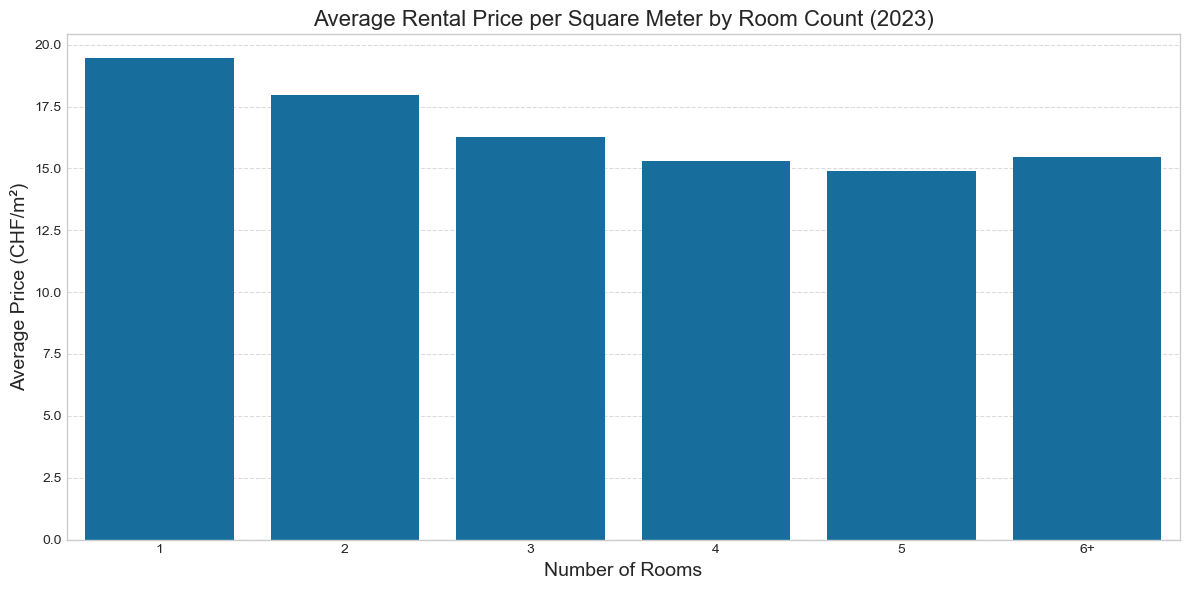

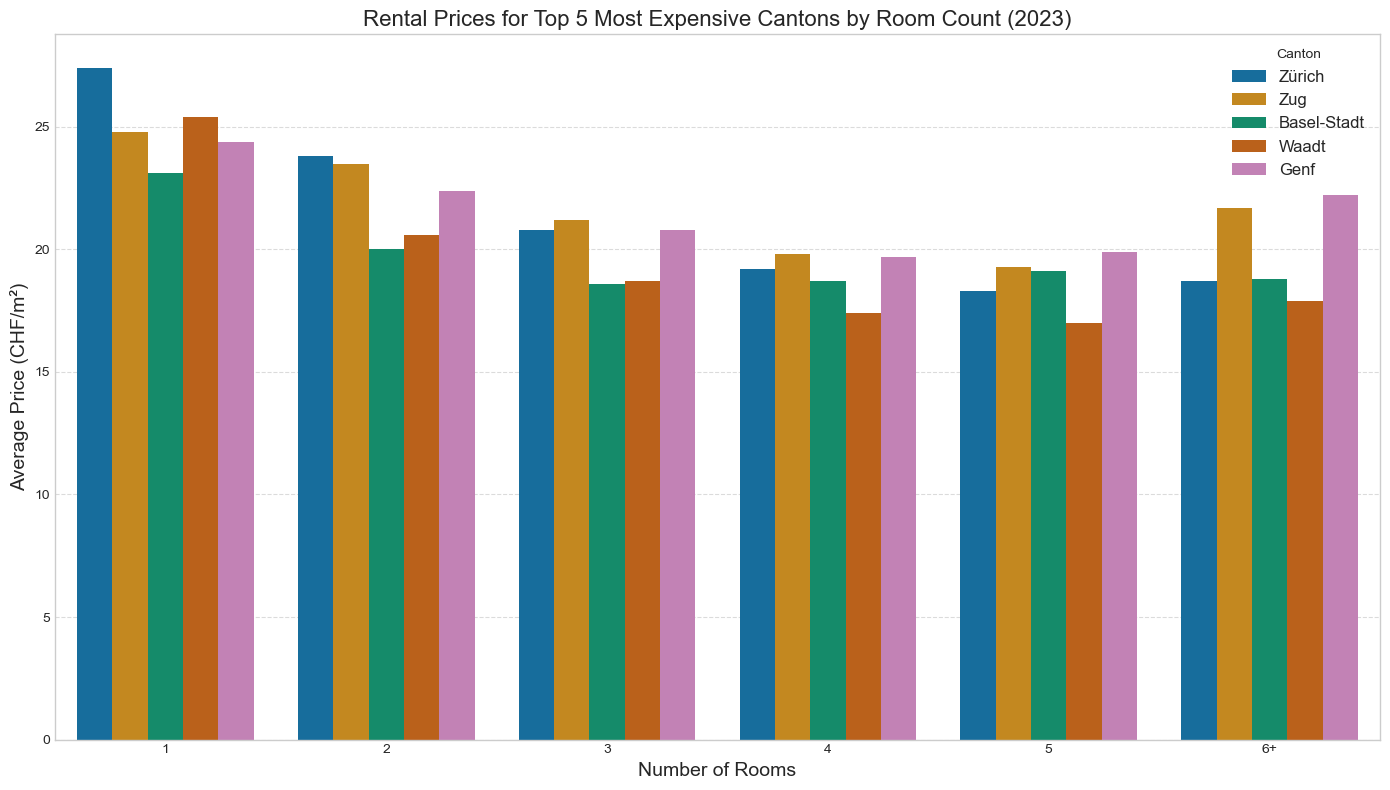

In [12]:
if data_dict:
    # Combine all data
    combined_df = pd.concat(data_dict.values(), ignore_index=True)
    
    # Use the most recent year if multiple years exist
    years = combined_df['year'].unique()
    if len(years) > 1:
        try:
            # Convert to numeric if possible
            years_numeric = pd.to_numeric(years, errors='coerce')
            latest_year = str(int(max(years_numeric[~pd.isna(years_numeric)])))
        except:
            # If conversion fails, use the last year in the list
            latest_year = years[-1]
        plot_df = combined_df[combined_df['year'] == latest_year]
    else:
        plot_df = combined_df
    
    # Create a categorical order for room counts
    room_order = sorted(plot_df['room_count'].unique(), 
                        key=lambda x: float(x.replace('+', '.5')) if x.replace('+', '.5').replace('.', '').isdigit() else 999)
    
    # Plot average price by room count
    plt.figure(figsize=(12, 6))
    sns.barplot(x='room_count', y='avg_price_per_sqm', 
                data=plot_df, 
                order=room_order,
                ci=None)
    plt.title(f'Average Rental Price per Square Meter by Room Count ({plot_df["year"].iloc[0]})', fontsize=16)
    plt.xlabel('Number of Rooms', fontsize=14)
    plt.ylabel('Average Price (CHF/m²)', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Get top 5 most expensive cantons
    top_cantons = plot_df.groupby('canton')['avg_price_per_sqm'].mean().nlargest(5).index
    
    # Plot detailed data for top cantons
    plt.figure(figsize=(14, 8))
    top_cantons_df = plot_df[plot_df['canton'].isin(top_cantons)]
    
    sns.barplot(x='room_count', y='avg_price_per_sqm', 
                hue='canton', 
                data=top_cantons_df,
                order=room_order)
    
    plt.title(f'Rental Prices for Top 5 Most Expensive Cantons by Room Count ({plot_df["year"].iloc[0]})', fontsize=16)
    plt.xlabel('Number of Rooms', fontsize=14)
    plt.ylabel('Average Price (CHF/m²)', fontsize=14)
    plt.legend(title='Canton', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

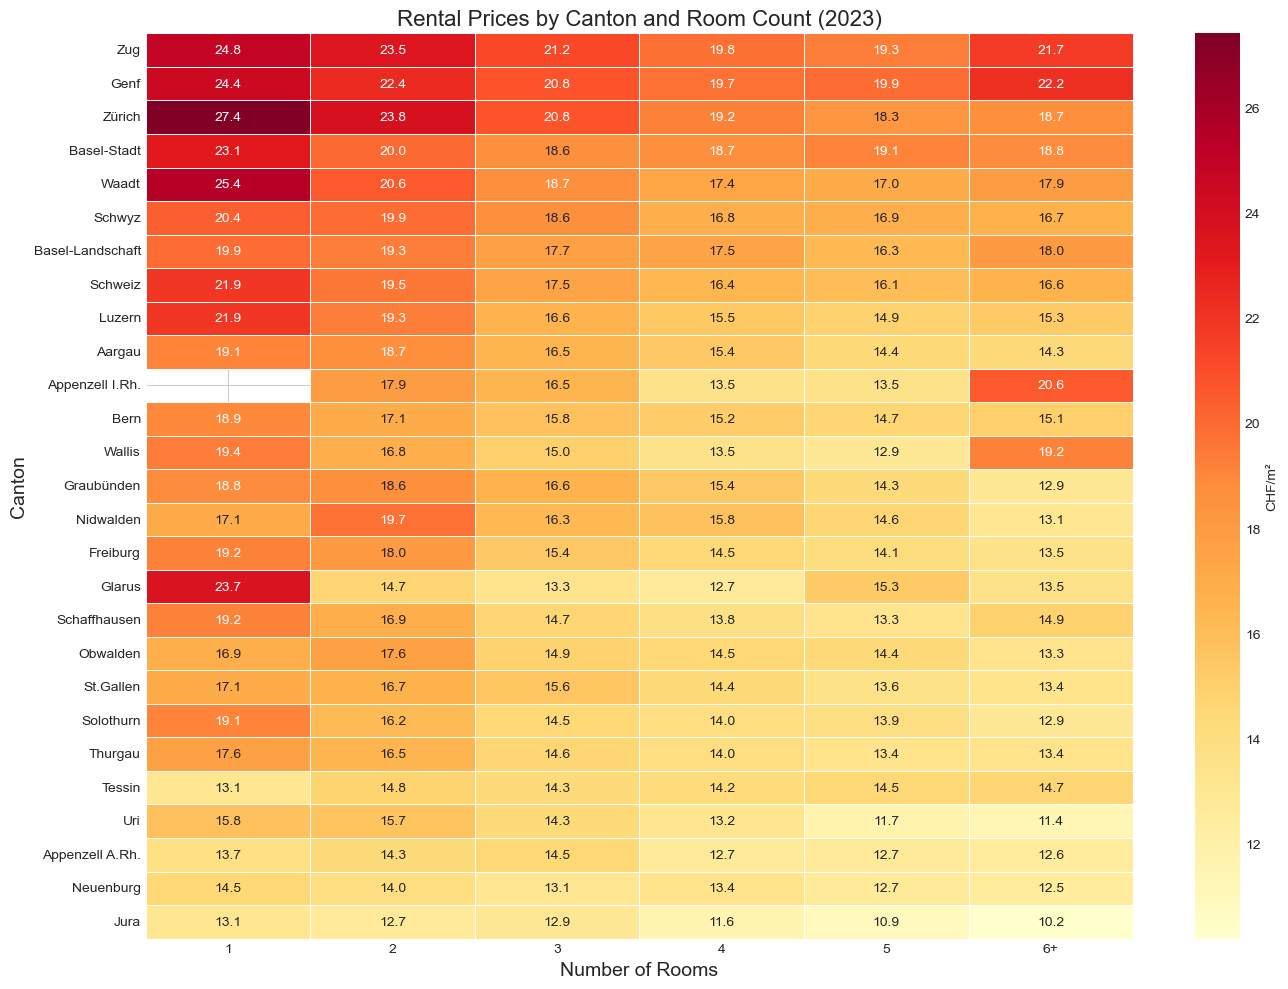

In [13]:
if data_dict and len(plot_df) > 0:
    # Create pivot table for heatmap
    pivot = pd.pivot_table(
        plot_df, 
        values='avg_price_per_sqm', 
        index='canton', 
        columns='room_count',
        aggfunc='mean'
    )
    
    # Sort cantons by average price
    canton_avg = plot_df.groupby('canton')['avg_price_per_sqm'].mean().sort_values(ascending=False)
    pivot = pivot.loc[canton_avg.index]
    
    # Reorder columns by room count
    if all(col in room_order for col in pivot.columns):
        pivot = pivot[room_order]
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=0.5, cbar_kws={'label': 'CHF/m²'})
    plt.title(f'Rental Prices by Canton and Room Count ({plot_df["year"].iloc[0]})', fontsize=16)
    plt.xlabel('Number of Rooms', fontsize=14)
    plt.ylabel('Canton', fontsize=14)
    plt.tight_layout()
    plt.show()

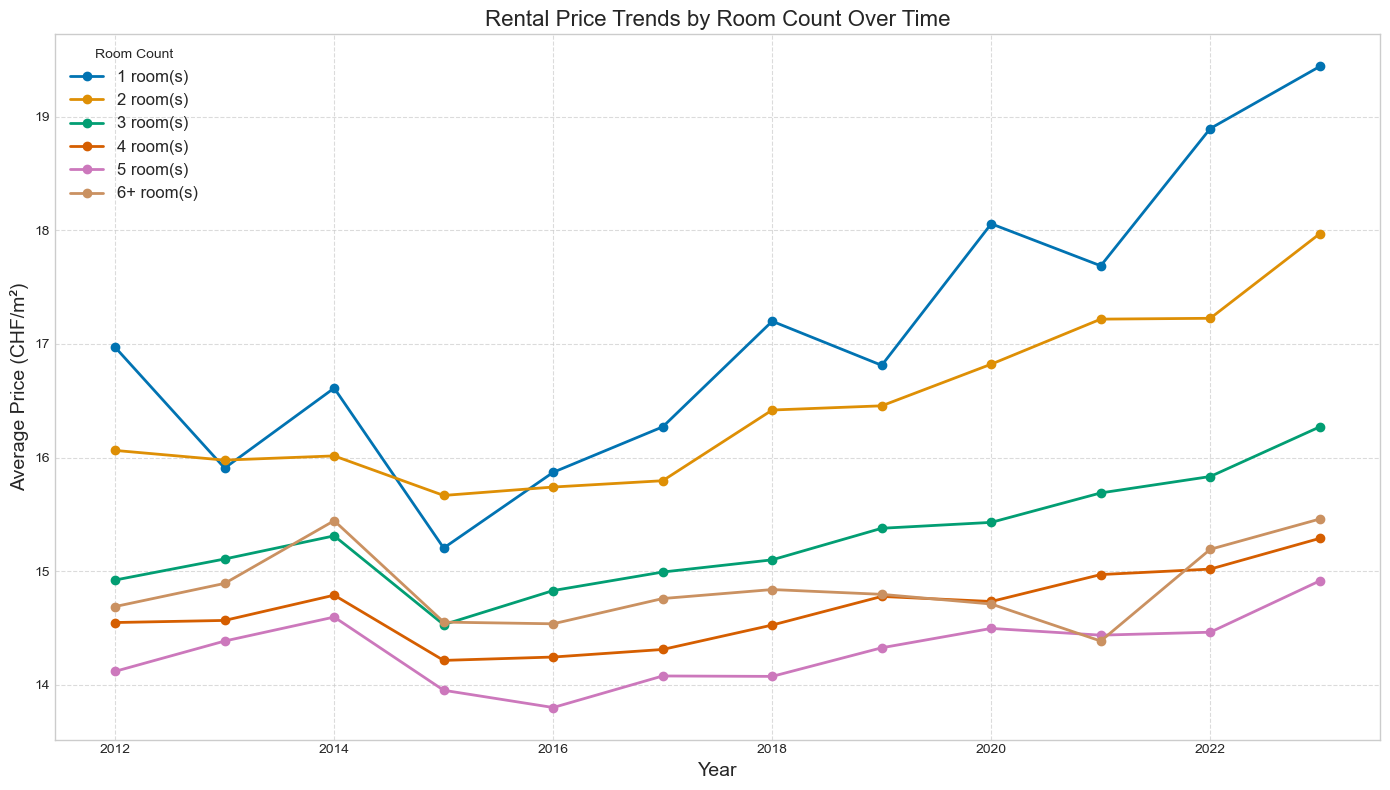

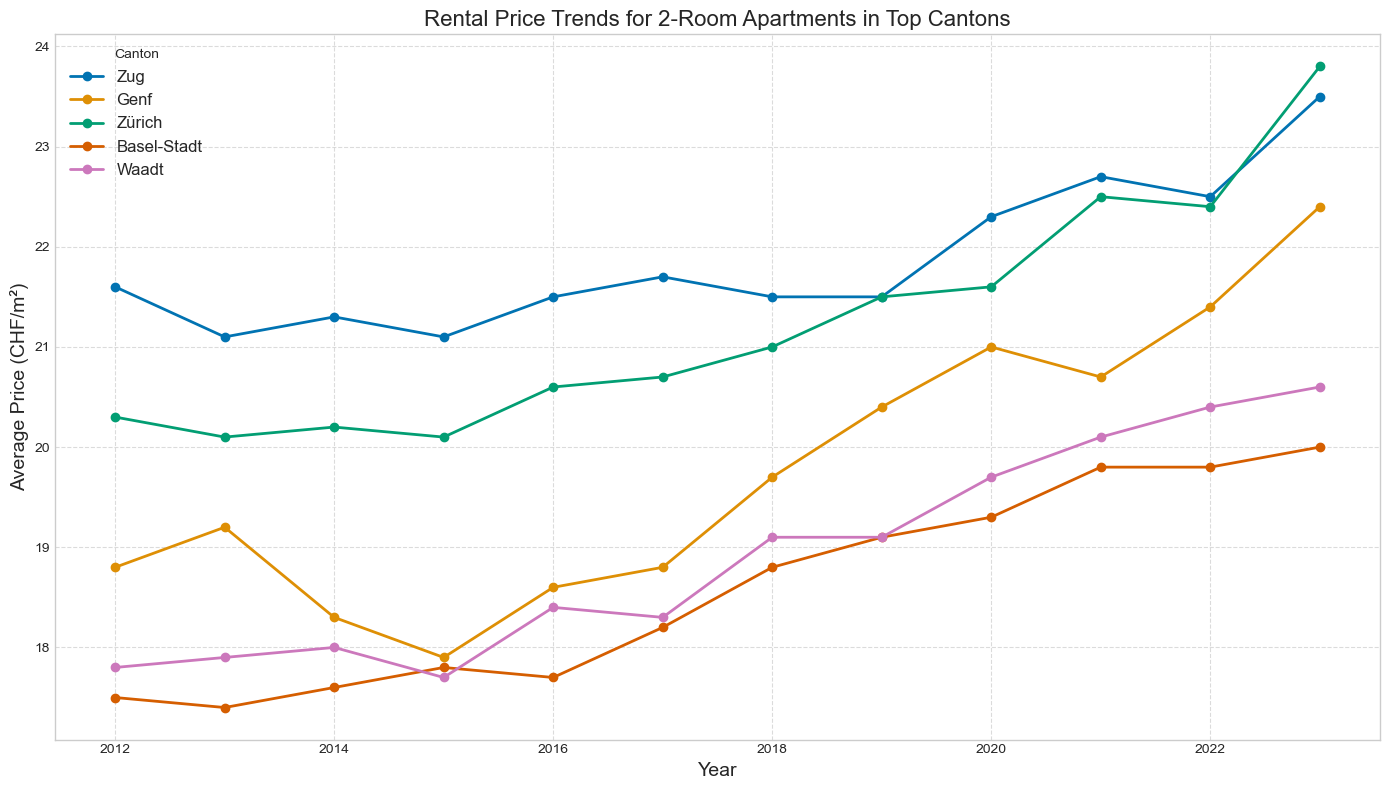

In [14]:
if data_dict and len(years) > 1:
    # Try to convert years to numeric for proper plotting
    combined_df['year_numeric'] = pd.to_numeric(combined_df['year'], errors='coerce')
    
    # Only proceed if we have valid numeric years
    if combined_df['year_numeric'].notna().any():
        # Filter to only rows with valid years
        time_df = combined_df[combined_df['year_numeric'].notna()].copy()
        time_df = time_df.sort_values('year_numeric')
        
        # Plot trends over time by room count
        plt.figure(figsize=(14, 8))
        
        for room in room_order:
            room_data = time_df[time_df['room_count'] == room]
            if len(room_data) > 0:
                room_avg = room_data.groupby('year_numeric')['avg_price_per_sqm'].mean()
                plt.plot(room_avg.index, room_avg.values, marker='o', linewidth=2, label=f'{room} room(s)')
        
        plt.title('Rental Price Trends by Room Count Over Time', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Average Price (CHF/m²)', fontsize=14)
        plt.legend(title='Room Count', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Plot trends for a specific room count across top cantons
        reference_room = room_order[1] if len(room_order) > 1 else room_order[0]  # Choose the second room category (often 2 rooms)
        
        plt.figure(figsize=(14, 8))
        
        for canton in top_cantons:
            canton_data = time_df[(time_df['canton'] == canton) & (time_df['room_count'] == reference_room)]
            if len(canton_data) > 0:
                plt.plot(canton_data['year_numeric'], canton_data['avg_price_per_sqm'], 
                         marker='o', linewidth=2, label=canton)
        
        plt.title(f'Rental Price Trends for {reference_room}-Room Apartments in Top Cantons', fontsize=16)
        plt.xlabel('Year', fontsize=14)
        plt.ylabel('Average Price (CHF/m²)', fontsize=14)
        plt.legend(title='Canton', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

C:\Users\Nevin\AppData\Local\Temp\ipykernel_35704\3857105669.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['room_count_num'] = plot_df['room_count'].apply(clean_room_count)


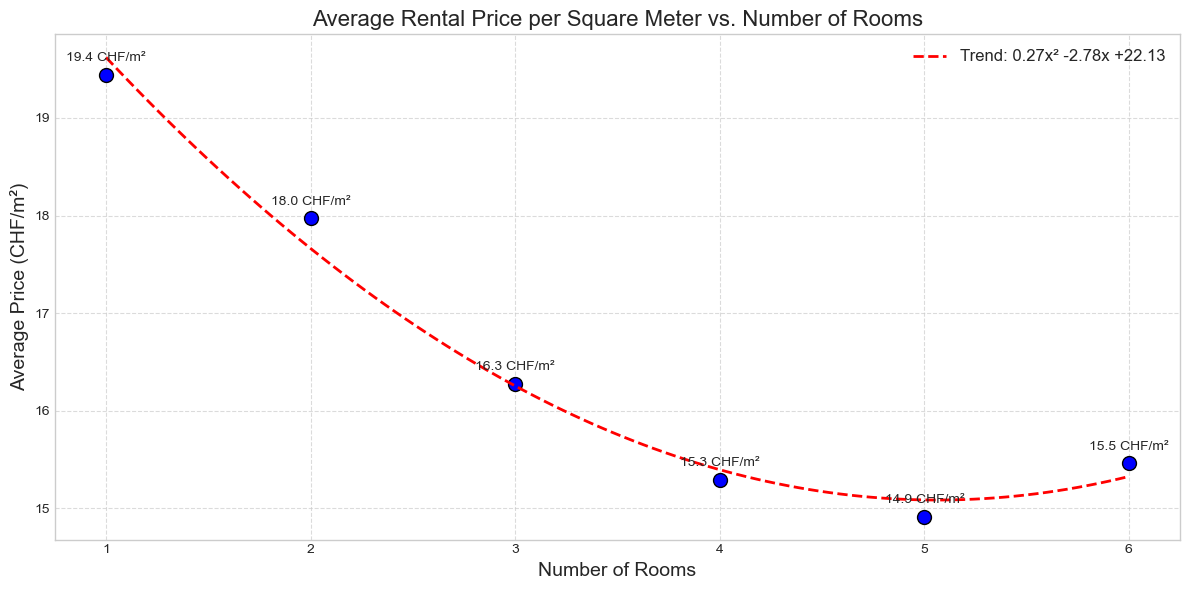


Interpretation:
Correlation between number of rooms and price per m²: -0.9007
There is a strong negative correlation: as the number of rooms increases, the price per m² tends to decrease.
This supports the economic principle of diminishing marginal utility in housing.


In [15]:
if data_dict:
    # Convert room count to numeric for modeling
    # For categories like '6+', we'll convert to 6
    def clean_room_count(room):
        # Remove '+' and convert to float
        return float(str(room).replace('+', ''))
    
    plot_df['room_count_num'] = plot_df['room_count'].apply(clean_room_count)
    
    # Calculate average prices by room count
    room_avg = plot_df.groupby('room_count_num')['avg_price_per_sqm'].mean().reset_index()
    
    # Plot the relationship
    plt.figure(figsize=(12, 6))
    plt.scatter(room_avg['room_count_num'], room_avg['avg_price_per_sqm'], s=100, color='blue', edgecolor='black')
    
    # Add labels for each point
    for i, row in room_avg.iterrows():
        plt.annotate(f"{row['avg_price_per_sqm']:.1f} CHF/m²", 
                   (row['room_count_num'], row['avg_price_per_sqm']),
                   textcoords="offset points", 
                   xytext=(0,10), 
                   ha='center')
    
    # Fit a trend line
    try:
        # Use polynomial regression for a better fit
        z = np.polyfit(room_avg['room_count_num'], room_avg['avg_price_per_sqm'], 2)
        p = np.poly1d(z)
        
        # Generate points for the trend line
        x_fit = np.linspace(room_avg['room_count_num'].min(), room_avg['room_count_num'].max(), 100)
        y_fit = p(x_fit)
        
        # Plot the trend line
        plt.plot(x_fit, y_fit, 'r--', linewidth=2, 
                 label=f'Trend: {z[0]:.2f}x² {z[1]:+.2f}x {z[2]:+.2f}')
        plt.legend(fontsize=12)
    except:
        # If the fit fails, just continue without the trend line
        pass
    
    plt.title('Average Rental Price per Square Meter vs. Number of Rooms', fontsize=16)
    plt.xlabel('Number of Rooms', fontsize=14)
    plt.ylabel('Average Price (CHF/m²)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(room_avg['room_count_num'])
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print("\nInterpretation:")
    if len(room_avg) > 1:
        room_corr = room_avg['room_count_num'].corr(room_avg['avg_price_per_sqm'])
        print(f"Correlation between number of rooms and price per m²: {room_corr:.4f}")
        
        if room_corr < -0.5:
            print("There is a strong negative correlation: as the number of rooms increases, the price per m² tends to decrease.")
            print("This supports the economic principle of diminishing marginal utility in housing.")
        elif room_corr > 0.5:
            print("There is a strong positive correlation: as the number of rooms increases, the price per m² tends to increase.")
            print("This might indicate that larger apartments are in higher demand or are of higher quality.")
        else:
            print("There is no strong linear correlation between the number of rooms and price per m².")